# Vision Mapping

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/auto-d/vision-mapping/blob/main/viz_map.ipynb)

This notebook explores the use of class activation maps (CAM) to help explain model classifications of security camera stills. The base model used for classification is [ResNet50](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py).

## Dependencies

We'll make use of the python `grad-cam` library due to its superior documentation. Ensure prerequisities are installed. 

In [776]:
!pip install grad-cam 

Helpers to identify presence/absence of GPUs for batch testing. 

In [1]:
import os
import torch

In [2]:
def check_acceleration():
    """
    Check for acceleration/GPU and return an indicator
    """
    device = None
    gpus = torch.cuda.is_available()
    if gpus:
        device = "cuda"
        print("GPU acceleration appears to be available!")
        for device in range(1, torch.cuda.device_count()):
            print(f"Found {torch.cuda.get_device_name(device)}")
    else:
        device = "cpu"
        print("GPU resources not found, defaulting to CPU.")

    return device

In [3]:
device = check_acceleration()

GPU resources not found, defaulting to CPU.


In [4]:
def inspect_model_file(path, device):
    """
    Inspect a torch .pth
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model file {path} doesn't exist!")
    kwargs = {} if device == "cuda" else { "map_location": torch.device('cpu') }
    data = torch.load(path, **kwargs)
    print(type(data))
    for k, v in data.items():
        print(k, v.shape)

## Resnet

Resnet is a venerable image classifier and will serve as our explainability target. We'll use the 50-layer variant with the architecture called out below. 

![resnet50](./resnet50.png)

In [5]:
import cv2 
import numpy as np 
%matplotlib inline
from matplotlib import pyplot as plt
from torch.nn.functional import softmax, interpolate
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

We'll pass a test image through to ensure the model is correctly loading and predicting. Note this Resnet version was applied to ImageNet and thus emits logics for the the 1000 ImageNet classes it learned during training. 

In [64]:
sample_image = "data/imagenet_2.jpg"
img = read_image(sample_image)

In [24]:
def torch_to_cv2(img): 
    """
    Torchvision image (c, h, w) -> OpenCV image (h,w,c)
    """
    return img.permute(1, 2, 0)

def cv2_to_torch(img): 
    """
    OpenCV image (h,w,c) -> Torchvision image (c, h, w) 
    """
    return img.permute(2, 0, 1)


In [25]:
def print_resnet_topk(probs, k=5):

    classes = ResNet50_Weights.DEFAULT.meta["categories"]

    topk = torch.topk(probs, k)
    print("Top predictions, in descending order:")
    for prob, ix in zip(topk[0], topk[1]): 
        print(f"- {classes[ix]} (label={ix}, p={prob:.3f})")

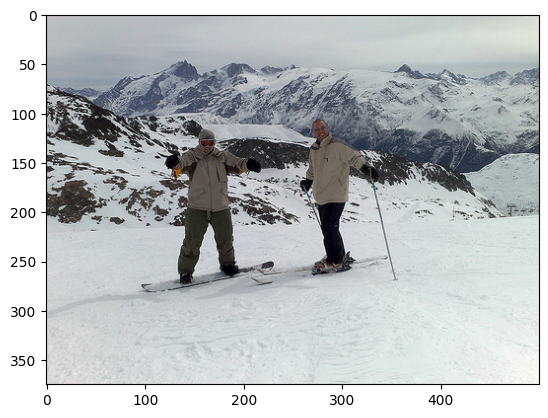

In [26]:
_ = plt.imshow(torch_to_cv2(img))

Scale the image to our Resnet input dimensions and obtain logits. 

In [27]:
img_scaled = img / 255.
img_square = resize(img_scaled, (224,224))
input_tensor = normalize(
    tensor=img_square, 
    mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225])

In [28]:
model = resnet50(pretrained=True).eval()
logits = model(input_tensor.unsqueeze(0))

Now obtain probabilities and top predicted classes. 

In [29]:
def print_resnet_topk(out, k=5):
    """
    Emit predictions based on provided probabilities for the 1000 imagenet classes that resnet  
    predicts. 
    """

    # Class mapping from https://docs.pytorch.org/vision/main/models.html
    classes = ResNet50_Weights.DEFAULT.meta["categories"]

    probs = torch.nn.functional.softmax(out, dim=1).detach().flatten()
    topk = torch.topk(probs, k)
    print("Top predictions, in descending order:")
    for prob, ix in zip(topk[0], topk[1]): 
        print(f"- {classes[ix]} (label={ix}, p={prob:.3f})")

In [31]:
print_resnet_topk(logits)

Top predictions, in descending order:
- ski (label=795, p=0.923)
- alp (label=970, p=0.076)
- shovel (label=792, p=0.000)
- dogsled (label=537, p=0.000)
- mountain tent (label=672, p=0.000)


The model correctly classifies this as ski scene, though resnet only gets one vote here. There are other, distant classes that are also not entirely inappropriate. 

## Application: Security Camera Footage Classification

One of us (okay me) has this half-baked idea of using resnet to serve as a speedy classifier of video stills from security camera streams. We've created a custom dataset of stills from a video camera feed and we'll experiment on those. 

In [14]:
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM, HiResCAM, EigenCAM

In [47]:
def prep_image(path): 
    """
    Load an image off disk, normalize it and return a tensor representing in the torchvision 
    format: (c, h, w)
    """
    rgb = cv2.imread(path, 1)[:, :, ::-1]
    rgb = np.float32(rgb) / 255
    tensor = preprocess_image(
        rgb,
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
    
    return rgb, tensor

Load an image, obtinaing a tensor with our normalized pixel values to pass to torch in the process. Here we see a very typical scene, with a delivery in progress to this porch. 

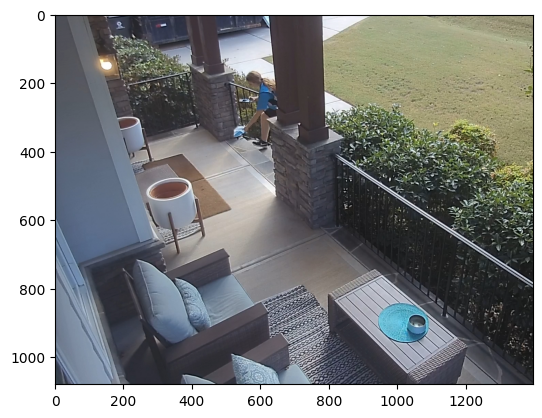

In [48]:
img, input_tensor = prep_image("./data/porch1.jpg")
plt.imshow(img)

In [49]:
logits = model(input_tensor)
print_resnet_topk(logits)

Top predictions, in descending order:
- solar dish (label=807, p=0.029)
- bannister (label=421, p=0.021)
- window screen (label=904, p=0.021)
- ashcan (label=412, p=0.019)
- pot (label=738, p=0.014)


Okay, so our application is already looking a little dicey. Here we have a partially occluded Amazon delivery person in the frame, but Resnet is more interested in the railing, and thinks the pots or perhaps the mat on the table is a solar dish. But, in defense of the model, we're probably pretty far outside the distribution of ImageNet training images, which often had a single prominent item in the image. Also in defense of the model, those probabilities are pretty low. 

### Explaining w/ GradCAM

GradCAM is a method for enriching classifications based on the visual features that underpinned those classifications. The technique is outlined in [this paper](https://arxiv.org/abs/1610.02391). GradCAM ties the gradients of one or more feature maps to the network's prediction, giving us an appreciation for which pixels had outsize bearing on the class prediction. Below is a diagram from the original paper that illustrates how filter gradients are joined with class predictions and the notional applications. 

![gradcam diagram](./doc/gradcam.png)

As illustrated in the above diagram, GradCAM needs to inspect (hook) a layer in the network to extract gradients from. Here we look at the output of the last layer of feature maps in the model.

In [50]:
target_layers = model.layer4

We instantiate the GradCAM helper, passing our target model and a reference to the layer we want to mine gradients from. Then retrieve an activation map given a specific example. 

In [51]:
cam = GradCAM(model=model, target_layers=target_layers)
gray_cam = cam(
    input_tensor=input_tensor, 
    targets=None, 
    aug_smooth=False, 
    eigen_smooth=False)[0, :]

Now overlay a heatmap of the activated pixels, scaled back up to the original image resolution so we can try to make sense of the activations and in turn, the prediction. 

In [52]:
cam_image = show_cam_on_image(img, gray_cam, use_rgb=True)

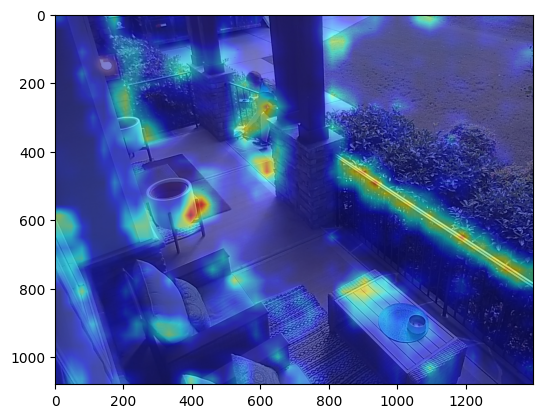

In [53]:
plt.imshow(cam_image)

We get some hints as to the models confusion here. In lieu of a single object activating, we have mild activations all over the image. The rationale for the tenuous classification of `bannister` or `satellite dish` become apparent, with the railing and the pot's legs getting some attention. 

Let's make this more repeatable and validate the processing on our original test image. 

In [56]:
def predict_and_explain(model, target, image_path, variant=GradCAM): 
    """
    Classify the image provided and then explain said prediction with a GradCAM variation
    """
    img, input_tensor = prep_image(image_path)
    plt.imshow(img)
    plt.title(f"Provided image {image_path}")

    logits = model(input_tensor)
    print_resnet_topk(logits)

    cam = GradCAM(model=model, target_layers=target)
    gray_cam = cam(
        input_tensor=input_tensor, 
        targets=None, 
        aug_smooth=False, 
        eigen_smooth=False)[0, :]
    
    cam_image = show_cam_on_image(img, gray_cam, use_rgb=True)
    plt.imshow(cam_image)
    plt.title(f"GradCAM-based activations")

Top predictions, in descending order:
- ski (label=795, p=0.749)
- alp (label=970, p=0.168)
- dogsled (label=537, p=0.020)
- mountain tent (label=672, p=0.011)
- snowmobile (label=802, p=0.009)


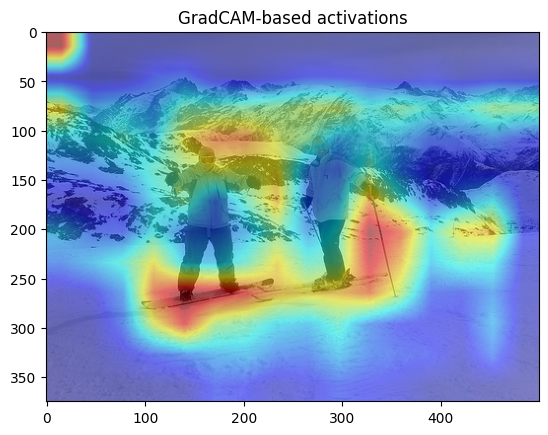

In [ ]:
predict_and_explain(model, target_layers, sample_image)

This is pretty convincing, we have some highly intuitive reflections of the `ski` label illuminated here by the gradient-based activation map. The skiier's pole, the snobarod, the mountains and the snow are all getting in on the prediction.

#### XGradCAM

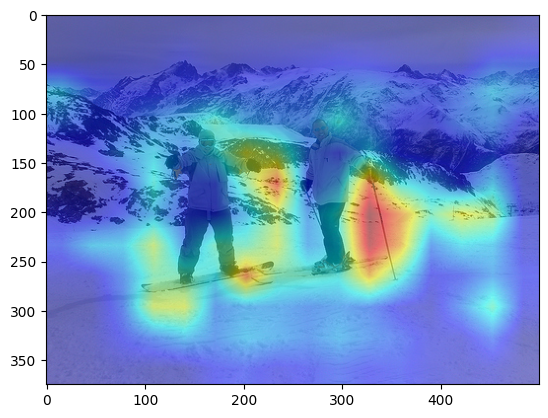

In [774]:
ecam = HiResCAM(model=model, target_layers=target_layers)
gray_cam = ecam(input_tensor2, targets=None, aug_smooth=False, eigen_smooth=False)[0, :] 
cam_image = show_cam_on_image(rgb_img, gray_cam, use_rgb=True)
plt.imshow(cam_image)

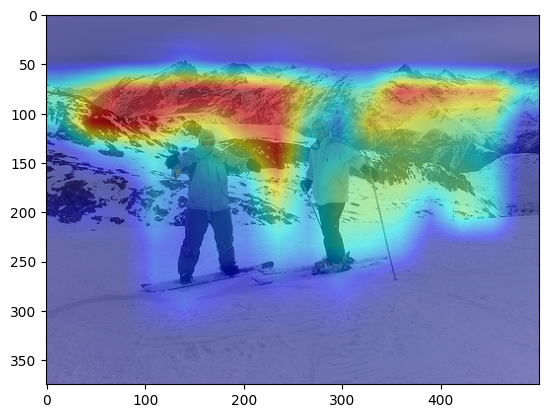

In [775]:
ecam = EigenCAM(model=model, target_layers=target_layers)
gray_cam = ecam(input_tensor2, targets=None, aug_smooth=False, eigen_smooth=False)[0, :] 
cam_image = show_cam_on_image(rgb_img, gray_cam, use_rgb=True)
plt.imshow(cam_image)